In [ ]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from sklearn.cluster import MiniBatchKMeans, KMeans
import matplotlib.pyplot as plt
import math
import os
import glob
from datetime import date, timedelta
import datetime

<h3>1. Reading Data</h3>

In [ ]:
# read all the csv files

data_path = './drive/MyDrive/gdrive/RecruitResturantCaseStudy/data'
processed_data = './drive/MyDrive/gdrive/RecruitResturantCaseStudy/processeddata'

#AIR Related Data
air_visit_data = pd.read_csv(data_path + "/air_visit_data.csv")
air_visit_data.visit_date = pd.to_datetime(air_visit_data.visit_date)
air_reservation_data = pd.read_csv(data_path + "/air_reserve.csv")
air_store_info = pd.read_csv(data_path + "/air_store_info.csv")

#Holiday info
date_info = pd.read_csv(data_path + "/date_info.csv")
date_info.calendar_date = pd.to_datetime(date_info.calendar_date)

#HPG Releated Data
hpg_reservation_data = pd.read_csv(data_path + "/hpg_reserve.csv")
hpg_store_info = pd.read_csv(data_path + "/hpg_store_info.csv")
store_id_relation = pd.read_csv(data_path + "/store_id_relation.csv")

#Sumbission File
submission = pd.read_csv(data_path + "/sample_submission.csv")

In [ ]:
# process the submission file
submission['air_store_id'] = submission.id.apply(lambda x: "_".join(x.split("_")[:2]))
submission['visit_date'] = submission.id.apply(lambda x: x.split("_")[2])
submission.drop("id", axis=1, inplace=True)
submission = submission[['air_store_id', 'visit_date', 'visitors']]
submission.visit_date = pd.to_datetime(submission.visit_date)
submission.head(3)



,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,0
1,air_00a91d42b08b08d9,2017-04-24,0
2,air_00a91d42b08b08d9,2017-04-25,0


In [ ]:
submission['is_train'] = False
air_visit_data['is_train'] = True

#Combain Train and Test Data
dataset = pd.concat([air_visit_data, submission])
dataset.head(3)

,air_store_id,visit_date,visitors,is_train
0,air_ba937bf13d40fb24,2016-01-13,25,True
1,air_ba937bf13d40fb24,2016-01-14,32,True
2,air_ba937bf13d40fb24,2016-01-15,29,True


<h3>Add Store Information to Dataset</h3>

In [ ]:
dataset = pd.merge(dataset, air_store_info, on='air_store_id',how='left')
print(dataset.shape)
dataset.head(3)

(284127, 8)


,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


Remove Outliers

In [ ]:
def calulate_IQR_outlier_range(df):
    
    q1, q3 = np.quantile(df.values, [0.25, 0.75])
    lower_IQR = q1 - (1.5 * (q3 - q1))
    higher_IQR = q3 + (1.5 * (q3 - q1))
    
    return min(higher_IQR, df.max())

def replace_outliers(df, max_data):
    
    temp = pd.merge(df, max_data, how='left', on='air_store_id')
    
    return np.where(temp.visitors < temp.max_visitor, temp.visitors, temp.max_visitor)

In [ ]:
stores = dataset[['air_store_id', 'visitors']].groupby('air_store_id')
max_store_vistors_capped = stores.apply(lambda x: calulate_IQR_outlier_range(x.visitors))
max_store_vistors_capped.name = 'max_visitor'
dataset['visitors_capped'] = replace_outliers(dataset[['air_store_id', 'visitors']], max_store_vistors_capped)

# add the log transformation of the visitors too
dataset['visitors_log1p'] = dataset.visitors.apply(lambda x: np.log1p(x))
dataset['visitors_capped_log1p'] = dataset.visitors_capped.apply(lambda x: np.log1p(x))
dataset.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p
0,air_ba937bf13d40fb24,2016-01-13,25,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,25.0,3.258097,3.258097
1,air_ba937bf13d40fb24,2016-01-14,32,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,32.0,3.496508,3.496508
2,air_ba937bf13d40fb24,2016-01-15,29,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,29.0,3.401197,3.401197


In [ ]:
dataset.to_csv(processed_data + '/' + 'processed_data_final.csv',index=False)

<h3>Areawise and Genre wise reataurant counts</h3>

In [ ]:
area_wise_store_count = air_store_info[['air_store_id', 'air_area_name']].groupby('air_area_name').count()
area_wise_store_count.rename(columns={'air_store_id': 'area_store_count'}, inplace=True)
dataset = pd.merge(dataset, area_wise_store_count, on='air_area_name', how='left')


area_wise_genre_count = air_store_info[['air_store_id', 'air_genre_name', 'air_area_name']].groupby(['air_area_name', 'air_genre_name']).count()
area_wise_genre_count.rename(columns={'air_store_id': 'area_genre_count'}, inplace=True)
dataset = pd.merge(dataset, area_wise_genre_count, how='left', on=['air_area_name', 'air_genre_name'])


In [ ]:
dataset.sort_values(['air_store_id', 'visit_date'], inplace=True)
dataset.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p,area_store_count,area_genre_count
87534,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,3.583519,20,4
87535,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,2.302585,20,4
87536,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,3.044522,20,4


In [ ]:
# get the reservations done on HPG
hpg_reserve = pd.merge(store_id_relation, hpg_reservation_data, how='left', on='hpg_store_id')
hpg_reserve.drop("hpg_store_id", axis=1, inplace=True)

# concat both AIR and HPG reservations
reservation_data = pd.concat([air_reservation_data, hpg_reserve])

# add the hour gap diff between reseravtion time as a feature
reservation_data.visit_datetime = pd.to_datetime(reservation_data.visit_datetime)
reservation_data.reserve_datetime = pd.to_datetime(reservation_data.reserve_datetime)
reservation_data['reservation_gap'] = reservation_data.visit_datetime - reservation_data.reserve_datetime
reservation_data['reservation_gap'] = reservation_data.reservation_gap / np.timedelta64(1,'h')

In [ ]:
reservation_data['hour_diff_lt_12'] = np.where(reservation_data.reservation_gap < 12, reservation_data.reserve_visitors, 0)
reservation_data['hour_diff_bt_12_36'] = np.where((reservation_data.reservation_gap >= 12) & \
                                                  (reservation_data.reservation_gap < 36), reservation_data.reserve_visitors, 0)
reservation_data['hour_diff_bt_36_59'] = np.where((reservation_data.reservation_gap >= 36) & \
                                                  (reservation_data.reservation_gap < 59), reservation_data.reserve_visitors, 0)
reservation_data['hour_diff_bt_59_85'] = np.where((reservation_data.reservation_gap >= 59) & \
                                                  (reservation_data.reservation_gap < 85), reservation_data.reserve_visitors, 0)
reservation_data['hour_diff_gt_85'] = np.where(reservation_data.reservation_gap >= 85, reservation_data.reserve_visitors, 0)

#Group by restaurant and visitdata and find sum for each category
reservation_data['visit_date'] = reservation_data.visit_datetime.dt.date

reserve_fetures_extract = reservation_data.groupby(['air_store_id','visit_date'],as_index=False)['hour_diff_lt_12', 'hour_diff_bt_12_36',\
                                                                                  'hour_diff_bt_36_59','hour_diff_bt_59_85',\
                                                                                  'hour_diff_gt_85'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# log transform the reservation featues
reservation_columns = reserve_fetures_extract.columns[2:]
for column in reservation_columns:
    reserve_fetures_extract[column] = reserve_fetures_extract[column].apply(lambda a: np.log1p(a))
reserve_fetures_extract.head(3)

,air_store_id,visit_date,hour_diff_lt_12,hour_diff_bt_12_36,hour_diff_bt_36_59,hour_diff_bt_59_85,hour_diff_gt_85
0,air_00a91d42b08b08d9,2016-01-14,0.0,0.0,0.0,1.098612,0.000000
1,air_00a91d42b08b08d9,2016-01-15,0.0,0.0,0.0,0.000000,1.609438
2,air_00a91d42b08b08d9,2016-01-16,0.0,0.0,0.0,1.098612,0.000000


In [ ]:
reserve_fetures_extract.visit_date = pd.to_datetime(reserve_fetures_extract.visit_date)
dataset = pd.merge(dataset, reserve_fetures_extract, how='left', on=['air_store_id', 'visit_date']).fillna(0)

<h3>Features from Holiday Flag</h3>

In [ ]:
# non working is a day if it is a weekend, or a holiday marked by holiday flag
date_info['non_working'] = np.where(date_info.day_of_week.isin(['Saturday', 'Sunday']) | (date_info.holiday_flg == 1), 1, 0)
date_info['prev_day_holiday'] = date_info['non_working'].shift().fillna(0)
date_info['next_day_holiday'] = date_info['non_working'].shift(-1).fillna(0)
date_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)
dataset = pd.merge(dataset, date_info, how='left', on='visit_date')
dataset.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p,area_store_count,area_genre_count,hour_diff_lt_12,hour_diff_bt_12_36,hour_diff_bt_36_59,hour_diff_bt_59_85,hour_diff_gt_85,day_of_week,holiday_flg,non_working,prev_day_holiday,next_day_holiday
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,3.583519,20,4,0.0,0.693147,0.0,0.0,0.0,Friday,0,0,0.0,1.0
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,2.302585,20,4,0.0,0.000000,0.0,0.0,0.0,Saturday,0,1,0.0,1.0
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,3.044522,20,4,0.0,0.000000,0.0,0.0,0.0,Monday,0,0,1.0,0.0


<h3>Weather Data Features</h3>

In [ ]:
# read weather data
weather_data = './drive/MyDrive/gdrive/RecruitResturantCaseStudy/weather_data'
weather_station_data = os.path.join(weather_data, "1-1-16_5-31-17_Weather/1-1-16_5-31-17_Weather")

air_store_near_station = pd.read_csv(weather_data + "/air_store_info_with_nearest_active_station.csv")
air_store_near_station = air_store_near_station.loc[:,['air_store_id', 'station_id']]
air_store_near_station = air_store_near_station.set_index('air_store_id')
air_store_weather_info = pd.DataFrame(columns=['calendar_date', 'avg_temperature',  'low_temperature', 'high_temperature','precipitation'])

for index, row in air_store_near_station.iterrows():
  weather_file = os.path.join(weather_station_data, row.station_id + ".csv")
  temp_weather = pd.read_csv(weather_file).loc[:, ['calendar_date', 'avg_temperature','low_temperature', 'high_temperature',\
                                                   'precipitation']]
  temp_weather.fillna(0, inplace=True)
  temp_weather['air_store_id'] = index

  air_store_weather_info = pd.concat([air_store_weather_info, temp_weather])


In [ ]:
air_store_weather_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)
air_store_weather_info.visit_date = pd.to_datetime(air_store_weather_info.visit_date)

dataset = pd.merge(dataset, air_store_weather_info, how='left', on=['air_store_id', 'visit_date'])
dataset.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p,area_store_count,area_genre_count,hour_diff_lt_12,hour_diff_bt_12_36,hour_diff_bt_36_59,hour_diff_bt_59_85,hour_diff_gt_85,day_of_week,holiday_flg,non_working,prev_day_holiday,next_day_holiday,avg_temperature,low_temperature,high_temperature,precipitation
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,3.583519,20,4,0.0,0.693147,0.0,0.0,0.0,Friday,0,0,0.0,1.0,25.6,22.0,30.6,0.0
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,2.302585,20,4,0.0,0.000000,0.0,0.0,0.0,Saturday,0,1,0.0,1.0,27.0,23.4,31.8,0.0
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,3.044522,20,4,0.0,0.000000,0.0,0.0,0.0,Monday,0,0,1.0,0.0,27.8,23.6,33.8,1.5


<h3>Date Features</h3>

In [ ]:
dataset['visit_day'] = dataset.visit_date.dt.day
dataset['visit_month'] = dataset.visit_date.dt.month
dataset['visit_year'] = dataset.visit_date.dt.year
dataset['visit_week'] = dataset.visit_date.dt.weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


<h3>Monthly visitors statistics</h3>

In [ ]:
# calculating monthly visitors mean for each restaurants
month_wise_mean= dataset.groupby(['air_store_id','visit_month'],as_index=False)['visitors_capped'].mean()
month_wise_mean = month_wise_mean.pivot(index='air_store_id', columns='visit_month', values='visitors_capped').reset_index()
month_wise_mean.columns = ['air_store_id','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']

month_wise_mean_2= dataset.groupby(['air_store_id','visit_month'],as_index=False)['visitors_capped_log1p'].mean()
month_wise_mean_2 = month_wise_mean_2.pivot(index='air_store_id', columns='visit_month', values='visitors_capped_log1p').reset_index()
month_wise_mean_2.columns = ['air_store_id','m1_log1p','m2_log1p','m3_log1p','m4_log1p','m5_log1p','m6_log1p','m7_log1p','m8_log1p','m9_log1p',
                           'm10_log1p','m11_log1p','m12_log1p']


# merging with train & test dataset 
dataset = dataset.merge(month_wise_mean,on='air_store_id',how='left')
dataset = dataset.merge(month_wise_mean_2,on='air_store_id',how='left')

In [ ]:
# storeId, nonworking
# average 
mean_visitor_working_1 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.mean()
mean_visitor_working_1.rename(columns={'visitors_capped': 'mean_visitors_cap_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, mean_visitor_working_1, how='left', on=['air_store_id', 'non_working'])

# Median 
median_visitor_working_1 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.median()
median_visitor_working_1.rename(columns={'visitors_capped': 'median_visitors_cap_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, median_visitor_working_1, how='left', on=['air_store_id', 'non_working'])

# minimum
min_visitor_working_1 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.min()
min_visitor_working_1.rename(columns={'visitors_capped': 'min_visitors_cap_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, min_visitor_working_1, how='left', on=['air_store_id', 'non_working'])

# maximum
max_visitor_working_1 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.max()
max_visitor_working_1.rename(columns={'visitors_capped': 'max_visitors_cap_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, max_visitor_working_1, how='left', on=['air_store_id', 'non_working'])

# count
count_visitor_working_1 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.count()
count_visitor_working_1.rename(columns={'visitors_capped': 'count_visitors_cap_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, count_visitor_working_1, how='left', on=['air_store_id', 'non_working'])

In [ ]:
# store_id, day_of_week
# average
mean_visitor_working_2 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.mean()
mean_visitor_working_2.rename(columns={'visitors_capped': 'mean_visitors_cap_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, mean_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])

# Median 
median_visitor_working_2 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.median()
median_visitor_working_2.rename(columns={'visitors_capped': 'median_visitors_cap_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, median_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])

# minimum
min_visitor_working_2 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.min()
min_visitor_working_2.rename(columns={'visitors_capped': 'min_visitors_cap_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, min_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])

# maximum
max_visitor_working_2 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.max()
max_visitor_working_2.rename(columns={'visitors_capped': 'max_visitors_cap_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, max_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])

# count
count_visitor_working_2 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.count()
count_visitor_working_2.rename(columns={'visitors_capped': 'count_visitors_cap_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, count_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])

In [ ]:
# store_id
# average
mean_visitor_working_3 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped.mean()
mean_visitor_working_3.rename(columns={'visitors_capped': 'mean_visitors_cap_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, mean_visitor_working_3, how='left', on=['air_store_id'])

# Median 
median_visitor_working_3 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped.median()
median_visitor_working_3.rename(columns={'visitors_capped': 'median_visitors_cap_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, median_visitor_working_3, how='left', on=['air_store_id'])

# minimum
min_visitor_working_3 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped.min()
min_visitor_working_3.rename(columns={'visitors_capped': 'min_visitors_cap_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, min_visitor_working_3, how='left', on=['air_store_id'])

# maximum
max_visitor_working_3 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped.max()
max_visitor_working_3.rename(columns={'visitors_capped': 'max_visitors_cap_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, max_visitor_working_3, how='left', on=['air_store_id'])

# count
count_visitor_working_3 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped.count()
count_visitor_working_3.rename(columns={'visitors_capped': 'count_visitors_cap_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, count_visitor_working_3, how='left', on=['air_store_id'])

In [ ]:
# storeId, nonworking
# average
mean_visitor_working_4 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.mean()
mean_visitor_working_4.rename(columns={'visitors_capped_log1p': 'mean_visitors_cap_log1p_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, mean_visitor_working_4, how='left', on=['air_store_id', 'non_working'])

# Median 
median_visitor_working_4 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.median()
median_visitor_working_4.rename(columns={'visitors_capped_log1p': 'median_visitors_cap_log1p_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, median_visitor_working_4, how='left', on=['air_store_id', 'non_working'])

# minimum
min_visitor_working_4 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.min()
min_visitor_working_4.rename(columns={'visitors_capped_log1p': 'min_visitors_log1p_cap_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, min_visitor_working_4, how='left', on=['air_store_id', 'non_working'])

# maximum
max_visitor_working_4 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.max()
max_visitor_working_4.rename(columns={'visitors_capped_log1p': 'max_visitors_cap_log1p_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, max_visitor_working_4, how='left', on=['air_store_id', 'non_working'])

# count
count_visitor_working_4 = dataset.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.count()
count_visitor_working_4.rename(columns={'visitors_capped_log1p': 'count_visitors_cap_log1p_air_store_id_non_working'}, inplace=True)
dataset = pd.merge(dataset, count_visitor_working_4, how='left', on=['air_store_id', 'non_working'])

In [ ]:
# store_id, day_of_week
# average
mean_visitor_working_5 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.mean()
mean_visitor_working_5.rename(columns={'visitors_capped_log1p': 'mean_visitors_cap_log1p_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, mean_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])

# Median
median_visitor_working_5 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.median()
median_visitor_working_5.rename(columns={'visitors_capped_log1p': 'median_visitors_cap_log1p_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, median_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])

# minimum
min_visitor_working_5 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.min()
min_visitor_working_5.rename(columns={'visitors_capped_log1p': 'min_visitors_cap_log1p_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, min_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])

# maximum
max_visitor_working_5 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.max()
max_visitor_working_5.rename(columns={'visitors_capped_log1p': 'max_visitors_cap_log1p_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, max_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])

# count
count_visitor_working_5 = dataset.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.count()
count_visitor_working_5.rename(columns={'visitors_capped_log1p': 'count_visitors_cap_log1p_air_store_id_dow'}, inplace=True)
dataset = pd.merge(dataset, count_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])

In [ ]:
# store_id
# average
mean_visitor_working_6 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.mean()
mean_visitor_working_6.rename(columns={'visitors_capped_log1p': 'mean_visitors_cap_log1p_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, mean_visitor_working_6, how='left', on=['air_store_id'])

# Median 
median_visitor_working_6 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.median()
median_visitor_working_6.rename(columns={'visitors_capped_log1p': 'median_visitors_cap_log1p_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, median_visitor_working_6, how='left', on=['air_store_id'])

# minimum
min_visitor_working_6 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.min()
min_visitor_working_6.rename(columns={'visitors_capped_log1p': 'min_visitors_cap_log1p_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, min_visitor_working_6, how='left', on=['air_store_id'])

# maximum
max_visitor_working_6 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.max()
max_visitor_working_6.rename(columns={'visitors_capped_log1p': 'max_visitors_cap_log1p_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, max_visitor_working_6, how='left', on=['air_store_id'])

# count
count_visitor_working_6 = dataset.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.count()
count_visitor_working_6.rename(columns={'visitors_capped_log1p': 'count_visitors_cap_log1p_air_store_id'}, inplace=True)
dataset = pd.merge(dataset, count_visitor_working_6, how='left', on=['air_store_id'])

In [ ]:
dataset.to_csv(processed_data + '/' + 'processed_data.csv',index=False)

<h3>Sub areas in Japan</h3>

In [ ]:
dataset['area_prefecture'] = dataset.air_area_name.apply(lambda x: x.split()[0])
dataset['area_sub_prefecture'] = dataset.air_area_name.apply(lambda x: x.split()[1])

<h3> Nb. restaurants open on the visit week </h3>

In [ ]:
total_restaurants = air_store_info.air_store_id.unique()
air_visit_data.visit_date = pd.to_datetime(air_visit_data.visit_date)
air_visit_data['visit_year'] = air_visit_data.visit_date.dt.year
air_visit_data['visit_month'] = air_visit_data.visit_date.dt.month
air_visit_data['visit_day'] = air_visit_data.visit_date.dt.day
air_visit_data['visit_week'] = air_visit_data.visit_date.dt.weekofyear
# 52 weeks in the 2016
air_visit_data.loc[air_visit_data.visit_week == 53, 'visit_week'] = 0
submission.visit_date = pd.to_datetime(submission.visit_date)
submission['visit_year'] = submission.visit_date.dt.year
submission['visit_month'] = submission.visit_date.dt.month
submission['visit_day'] = submission.visit_date.dt.day
submission['visit_week'] = submission.visit_date.dt.weekofyear
# 52 weeks in the 2016
submission.loc[submission.visit_week == 53, 'visit_week'] = 0
#submission.drop("id", axis=1, inplace=True)

total_data = pd.concat([air_visit_data, submission])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [ ]:
week_list = list(total_data['visit_week'].unique())
year_list = list(total_data['visit_year'].unique())

year_week_count = []
for year in year_list:
    for week_num in week_list:
    
        count = len(list(total_data.loc[(total_data.visit_year ==year) & (total_data.visit_week == week_num),'air_store_id'].unique()))
         # upto may 2017
        if (year == 2017) and (week_num>22):
            break
        
        year_week_count.append([year, week_num, count])
        
columns = ['visit_year', 'visit_week', 'open_resturant_count']
restaurant_weekly_open = pd.DataFrame(year_week_count, columns=columns)

dataset = pd.merge(dataset, restaurant_weekly_open, how='left', on=['visit_year', 'visit_week'])

<h3>Number of Reservations on given Day</h3>

In [ ]:
reservation_count_feature = reservation_data.groupby(['air_store_id', 'visit_date'], as_index=False).visit_datetime.count()
reservation_count_feature.visit_date = pd.to_datetime(reservation_count_feature.visit_date)
reservation_count_feature.rename(columns={'visit_datetime' : 'reservation_count'}, inplace=True)
dataset = pd.merge(dataset, reservation_count_feature, how='left', on=['air_store_id', 'visit_date']).fillna(0)
dataset.reservation_count = dataset.reservation_count.apply(lambda x: np.log1p(x))

In [ ]:
# random features
dataset['lat+long'] = dataset.latitude + dataset.longitude
dataset['lat_max_diff'] = dataset.latitude.max() - dataset.latitude 
dataset['long_max_diff'] = dataset.longitude.max() - dataset.longitude 

<h3>Features Based on Latitude and Longitude</h3>

In [ ]:
def distance_to_center(latitude,logitude,cluster):
    p1=[latitude,logitude]
    p2=cluster_centers[cluster]
    
    return np.linalg.norm(p1 - p2) 

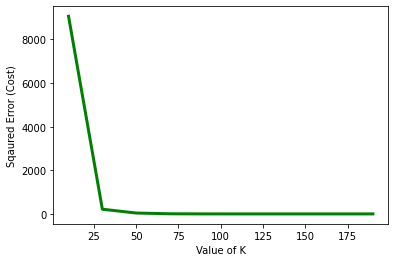

In [ ]:
cost =[]
for i in range(10, 200,20):
    KM = MiniBatchKMeans(n_clusters=i, batch_size=10000,random_state=0)
    KM.fit(dataset[['latitude','longitude']])
      
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)
  
# plot the cost against K values
plt.plot(range(10, 200,20), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(dataset[['latitude','longitude']])
dataset['location_cluster'] = kmeans.predict(dataset[['latitude', 'longitude']])
cluster_centers = kmeans.cluster_centers_


dataset['distace_to_center']=dataset.apply(lambda x: distance_to_center(x.latitude,x.longitude,x.location_cluster),axis=1)
dataset.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p,area_store_count,area_genre_count,hour_diff_lt_12,hour_diff_bt_12_36,hour_diff_bt_36_59,hour_diff_bt_59_85,hour_diff_gt_85,day_of_week,holiday_flg,non_working,prev_day_holiday,next_day_holiday,avg_temperature,low_temperature,high_temperature,precipitation,visit_day,visit_month,visit_year,visit_week,m1,m2,m3,m4,m5,m6,m7,m8,m9,...,m12_log1p,mean_visitors_cap_air_store_id_non_working,median_visitors_cap_air_store_id_non_working,min_visitors_cap_air_store_id_non_working,max_visitors_cap_air_store_id_non_working,count_visitors_cap_air_store_id_non_working,mean_visitors_cap_air_store_id_dow,median_visitors_cap_air_store_id_dow,min_visitors_cap_air_store_id_dow,max_visitors_cap_air_store_id_dow,count_visitors_cap_air_store_id_dow,mean_visitors_cap_air_store_id,median_visitors_cap_air_store_id,min_visitors_cap_air_store_id,max_visitors_cap_air_store_id,count_visitors_cap_air_store_id,mean_visitors_cap_log1p_air_store_id_non_working,median_visitors_cap_log1p_air_store_id_non_working,min_visitors_log1p_cap_air_store_id_non_working,max_visitors_cap_log1p_air_store_id_non_working,count_visitors_cap_log1p_air_store_id_non_working,mean_visitors_cap_log1p_air_store_id_dow,median_visitors_cap_log1p_air_store_id_dow,min_visitors_cap_log1p_air_store_id_dow,max_visitors_cap_log1p_air_store_id_dow,count_visitors_cap_log1p_air_store_id_dow,mean_visitors_cap_log1p_air_store_id,median_visitors_cap_log1p_air_store_id,min_visitors_cap_log1p_air_store_id,max_visitors_cap_log1p_air_store_id,count_visitors_cap_log1p_air_store_id,area_prefecture,area_sub_prefecture,open_resturant_count,reservation_count,lat+long,lat_max_diff,long_max_diff,location_cluster,distace_to_center
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,3.583519,20,4,0.0,0.693147,0.0,0.0,0.0,Friday,0,0,0.0,1.0,25.6,22.0,30.6,0.0,1,7,2016,26,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,3.230017,25.156682,27.0,0.0,57.00,217,32.444444,35.0,0.0,57.00,45,22.198339,23.0,0.0,63.75,271,2.928279,3.332205,0.0,4.060443,217,3.195653,3.583519,0.0,4.060443,45,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0,0.693147,175.447598,8.326629,4.519803,25,0.02744
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,2.302585,20,4,0.0,0.000000,0.0,0.0,0.0,Saturday,0,1,0.0,1.0,27.0,23.4,31.8,0.0,2,7,2016,26,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,3.230017,10.310185,7.0,0.0,63.75,54,12.412791,9.0,0.0,63.75,43,22.198339,23.0,0.0,63.75,271,1.832758,2.079442,0.0,4.170534,54,2.204169,2.302585,0.0,4.170534,43,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0,0.000000,175.447598,8.326629,4.519803,25,0.02744
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,3.044522,20,4,0.0,0.000000,0.0,0.0,0.0,Monday,0,0,1.0,0.0,27.8,23.6,33.8,1.5,4,7,2016,27,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,3.230017,25.156682,27.0,0.0,57.00,217,19.170732,18.0,0.0,47.00,41,22.198339,23.0,0.0,63.75,271,2.928279,3.332205,0.0,4.060443,217,2.609416,2.944439,0.0,3.871201,41,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,794.0,0.000000,175.447598,8.326629,4.519803,25,0.02744


In [ ]:
#Number of stores in the cluster
num_store_in_cluster = dataset.groupby(['air_store_id','location_cluster'],as_index=False)['location_cluster'].count()
num_store_in_cluster.rename({'location_cluster':'count_of_stores'},axis=1,inplace=True)

dataset = pd.merge(dataset,num_store_in_cluster,on='air_store_id',how='left')
dataset.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p,area_store_count,area_genre_count,hour_diff_lt_12,hour_diff_bt_12_36,hour_diff_bt_36_59,hour_diff_bt_59_85,hour_diff_gt_85,day_of_week,holiday_flg,non_working,prev_day_holiday,next_day_holiday,avg_temperature,low_temperature,high_temperature,precipitation,visit_day,visit_month,visit_year,visit_week,m1,m2,m3,m4,m5,m6,m7,m8,m9,...,mean_visitors_cap_air_store_id_non_working,median_visitors_cap_air_store_id_non_working,min_visitors_cap_air_store_id_non_working,max_visitors_cap_air_store_id_non_working,count_visitors_cap_air_store_id_non_working,mean_visitors_cap_air_store_id_dow,median_visitors_cap_air_store_id_dow,min_visitors_cap_air_store_id_dow,max_visitors_cap_air_store_id_dow,count_visitors_cap_air_store_id_dow,mean_visitors_cap_air_store_id,median_visitors_cap_air_store_id,min_visitors_cap_air_store_id,max_visitors_cap_air_store_id,count_visitors_cap_air_store_id,mean_visitors_cap_log1p_air_store_id_non_working,median_visitors_cap_log1p_air_store_id_non_working,min_visitors_log1p_cap_air_store_id_non_working,max_visitors_cap_log1p_air_store_id_non_working,count_visitors_cap_log1p_air_store_id_non_working,mean_visitors_cap_log1p_air_store_id_dow,median_visitors_cap_log1p_air_store_id_dow,min_visitors_cap_log1p_air_store_id_dow,max_visitors_cap_log1p_air_store_id_dow,count_visitors_cap_log1p_air_store_id_dow,mean_visitors_cap_log1p_air_store_id,median_visitors_cap_log1p_air_store_id,min_visitors_cap_log1p_air_store_id,max_visitors_cap_log1p_air_store_id,count_visitors_cap_log1p_air_store_id,area_prefecture,area_sub_prefecture,open_resturant_count,reservation_count,lat+long,lat_max_diff,long_max_diff,location_cluster,distace_to_center,count_of_stores
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,3.583519,20,4,0.0,0.693147,0.0,0.0,0.0,Friday,0,0,0.0,1.0,25.6,22.0,30.6,0.0,1,7,2016,26,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,25.156682,27.0,0.0,57.00,217,32.444444,35.0,0.0,57.00,45,22.198339,23.0,0.0,63.75,271,2.928279,3.332205,0.0,4.060443,217,3.195653,3.583519,0.0,4.060443,45,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0,0.693147,175.447598,8.326629,4.519803,25,0.02744,271
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,2.302585,20,4,0.0,0.000000,0.0,0.0,0.0,Saturday,0,1,0.0,1.0,27.0,23.4,31.8,0.0,2,7,2016,26,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,10.310185,7.0,0.0,63.75,54,12.412791,9.0,0.0,63.75,43,22.198339,23.0,0.0,63.75,271,1.832758,2.079442,0.0,4.170534,54,2.204169,2.302585,0.0,4.170534,43,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0,0.000000,175.447598,8.326629,4.519803,25,0.02744,271
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,3.044522,20,4,0.0,0.000000,0.0,0.0,0.0,Monday,0,0,1.0,0.0,27.8,23.6,33.8,1.5,4,7,2016,27,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,25.156682,27.0,0.0,57.00,217,19.170732,18.0,0.0,47.00,41,22.198339,23.0,0.0,63.75,271,2.928279,3.332205,0.0,4.060443,217,2.609416,2.944439,0.0,3.871201,41,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,794.0,0.000000,175.447598,8.326629,4.519803,25,0.02744,271


In [ ]:
dataset.drop('location_cluster',axis=1,inplace=True)
dataset.to_csv(processed_data + '/' + 'processed_data_final.csv',index=False)

<h3>8. Features Extracted:</h3>

<p>
<b>1. reserve_visitors:</b>  Number visitors using reservation on given day.<br>
<b>2. time_diff features:</b>  Time difference between reservation and visit time and divided into 5 catogories. time_diff1 if hour difference is less than 12, time_diff2 is 12 to 36, time_diff is 36 to 60, time_diff2 for 60 to 80 and ,more than 80 to time_diff_5.<br>
<b>3. day_of_week:</b>  Determins day of the week<br>
<b>4. Month:</b>  Determines Month<br>
<b>5. reserve visitors timings:</b>  Based on time of visit of reserved customers, count in morning, afternoon and  evening is divided.<br>
<b>6. Number of restaurants in Area:</b> Using Area name feature, we derived number of restaurants in same area.<br>
<b>7. same_genre_count: </b> Same Genre restaurant count in the same area.<br>
<b>8. distace_to_center: </b> CLustered the data using kmeans and found each restaurants distance to the center of cluster<br>
<b>9. number of stores in cluster: </b> CLustered the data using kmeans and found number of store in each cluster<br>
<b>10. Holiday:</b>  Holiday Flag determines given day is holiday/Not<br>
<b>11. prev_day_holiday :</b>  determines previous day is holiday or not. <br>
<b>12. next_day_holiday: </b> Determines Next day is holiday or not.<br>
<b>13. lat+long: </b> Sum of latitude and longitude<br>
<b>14. lat_max_diff: </b> Difference between max lagitude to location latitude<br>
<b>15. long_max_diff</b> Difference between max longitude to location latitude<br>
<b>16. stats on visitors (Holiday/Non-Holiday):</b> Mean, Median, Min and Max visitors to a restaurant, seperatly calculated for holiday and non holiday<br>
<b>17. stats on visitors(Monthly):</b>  Mean, Median, Min and Max visitors to a restaurant, on given month.<br>
</p>